---
title: "Analysis of Time-series Data"
format:
    html:
        toc: true
        highlight-style: ayu
---

On this project, we'll analyze the annual average temperature from [Peru](https://climateknowledgeportal.worldbank.org/country/peru/climate-data-historical).



In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show, export_png
# from bokeh.io import output_file
from bokeh.plotting import figure
from itertools import chain 
from sklearn.metrics import mean_squared_error
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import seaborn as sns
import math
import pmdarima as pm
import statsmodels.api as sm
def mean_absolute_percentage_error(y_true, y_pred): 
     return np.mean(np.abs((y_true - y_pred) / y_true)) *100
output_notebook()

Loading BokehJS ...

# Annual Average Temperature from Junin, Peru

First we need to load the data and create a single dataframe.

In [2]:
temp_df = pd.read_csv("observed-annual-average-mean-surface-air-temperature-of-junín,-peru-for-1901-2022.csv", sep=",")
temp_df = temp_df.rename(columns={"Category":"Year", "Annual Mean":"Temp_annual_mean"}).drop(columns=["5-yr smooth"])


prec_df = pd.read_csv("observed-annual-precipitation-of-junín,-peru-for-1901-2022.csv", sep=",")
prec_df = prec_df.rename(columns={"Category":"Year", "Annual Mean":"Prec_annual_mean"}).drop(columns=["5-yr smooth"])

climate_df = pd.merge(temp_df, prec_df, on="Year", how="left")
climate_df

,Year,Temp_annual_mean,Prec_annual_mean
0,1901,14.17,1273.85
1,1902,14.16,1273.85
2,1903,13.85,1273.85
3,1904,13.70,1273.85
4,1905,14.07,1273.85
...,...,...,...
117,2018,14.65,1273.85
118,2019,14.84,1262.93
119,2020,15.00,1273.85
120,2021,14.97,1046.47


Due to some rare measures on the data, let's subset the data from the year 1951.

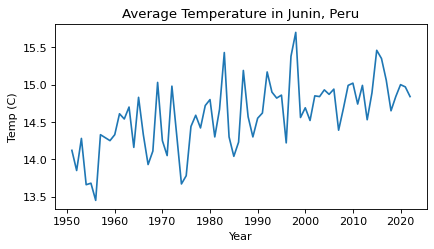

,Year,Temp_annual_mean,Prec_annual_mean
50,1951,14.12,1183.29
51,1952,13.85,1287.30
52,1953,14.28,1345.91
53,1954,13.66,1328.92
54,1955,13.68,1008.42


In [3]:
plt.figure(figsize=(6, 3), dpi=80)
subset_df = climate_df[climate_df.Year >= 1951] 

sns.lineplot(data=subset_df, x="Year", y="Temp_annual_mean")
plt.title("Average Temperature in Junin, Peru")
plt.ylabel('Temp (C)')
plt.show()
subset_df.head()

We can see the annual mean temperature training data.

## Removing the Trend

### Linear Trend

First let's define the functions to calculate the Akaike Information Criteria and the Bayesian Information Criteria to test the performance of our models.

In [4]:
from scipy.stats import norm 
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)

def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

Now, we can begin fitting a linear trend to the data.

[[0.01386713]]


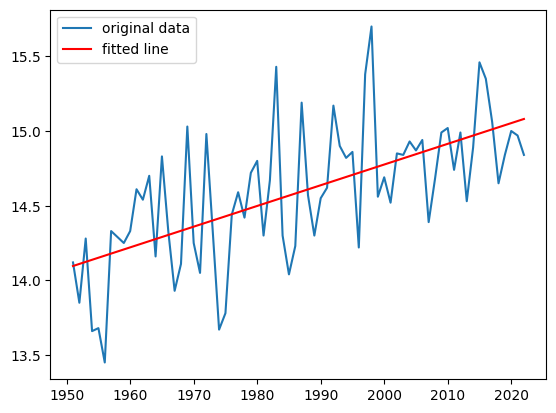

In [5]:
X = subset_df["Year"].values.reshape(-1,1)
y = subset_df["Temp_annual_mean"].values.reshape(-1,1)


linear_model = LinearRegression()
linear_model.fit(X, y)

print(linear_model.coef_)

y_hat = linear_model.predict(X)

plt.plot(X, y, label='original data')
plt.plot(X, y_hat, 'r', label='fitted line')
plt.legend()



And plot the residuals of the model.

MSE with linear fit: 0.12615193027776006
AIC: 57.2678309969092
BIC: 59.54449711592525


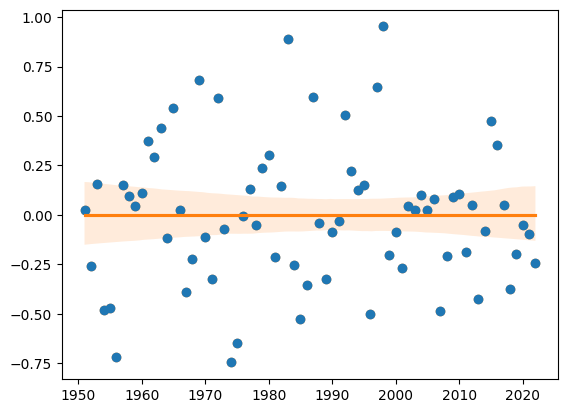

In [6]:
linear_residuals = y - y_hat
plt.plot(X, linear_residuals,'o')
sns.regplot(x=X, y=linear_residuals)

print("MSE with linear fit:", np.mean((linear_residuals)**2))
print("AIC:", evaluate_AIC(1, linear_residuals))
print("BIC:", evaluate_BIC(1, linear_residuals))

The plot shows a good distribution of the residuals.

Let's check the autocorrelation and partial autocorralation of the residuals.

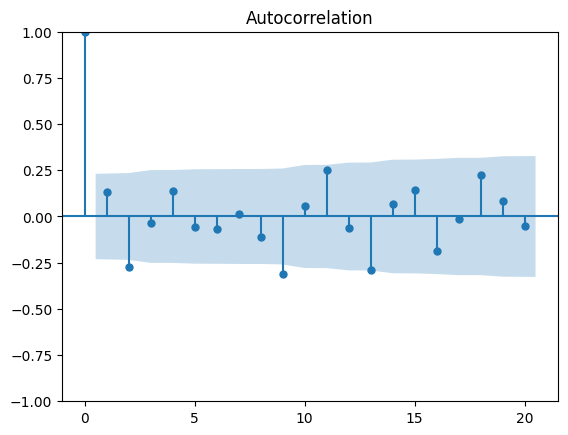

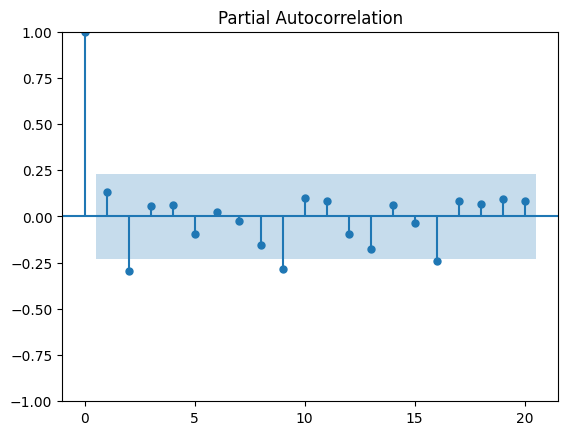

In [7]:
sm.graphics.tsa.plot_acf(linear_residuals, lags=20)
plt.show()
sm.graphics.tsa.plot_pacf(linear_residuals, lags=20)
plt.show()

It seems there is an autocorrelation structure on the data.

### Quadratic Trend

To check that the linear trend is a good choice, let'sw compare it with a quadratic fit.

[[ 5.74495264e-01 -1.41109523e-04]]


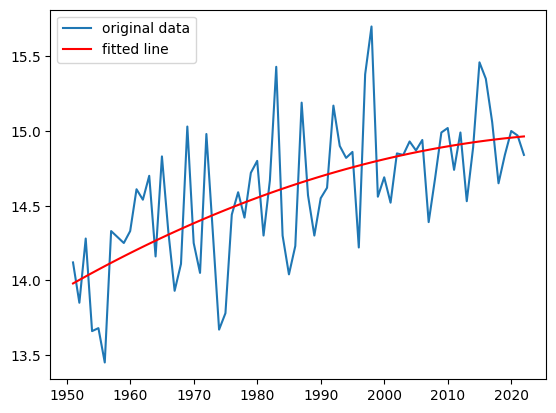

In [8]:
degree=2
quadratic_model=LinearRegression()

new_x = np.hstack((X, X **2))

quadratic_model.fit(new_x, y)
quadratic = quadratic_model.predict(new_x)

print(quadratic_model.coef_)

y_hat_quad = quadratic_model.predict(new_x)

plt.plot(X, y, label='original data')
plt.plot(X, y_hat_quad, 'r', label='fitted line')
plt.legend()


The residuals:

MSE with linear fit: 0.12318196679493859
AIC: 57.55248071646069
BIC: 62.105812954492805


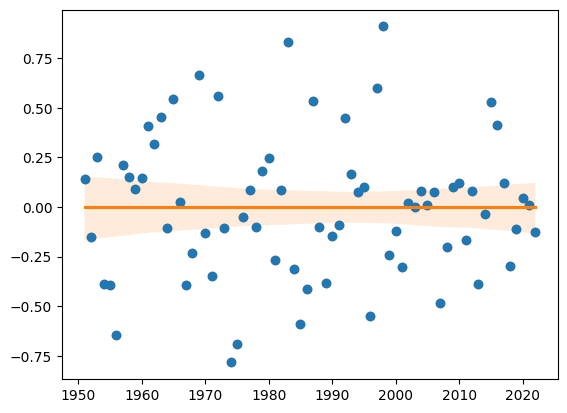

In [9]:
quadratic_residuals = y - y_hat_quad
plt.plot(X, quadratic_residuals,'o')
sns.regplot(x=X, y=quadratic_residuals)

print("MSE with linear fit:", np.mean((quadratic_residuals)**2))
print("AIC:", evaluate_AIC(2, quadratic_residuals))
print("BIC:", evaluate_BIC(2, quadratic_residuals))

And the autocorrelation plots.

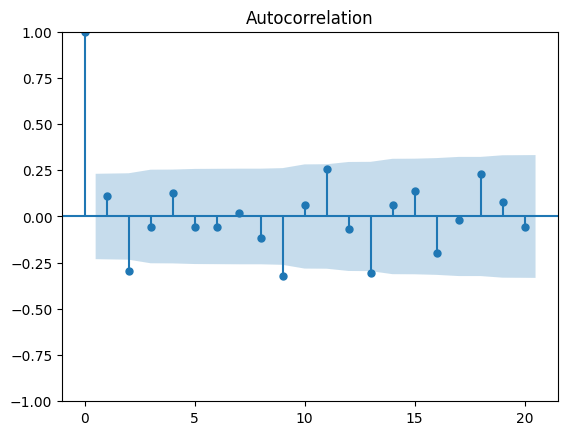

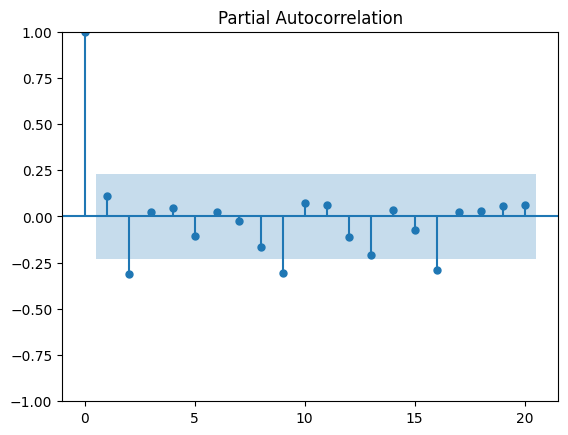

In [10]:
sm.graphics.tsa.plot_acf(quadratic_residuals, lags=20)
plt.show()
sm.graphics.tsa.plot_pacf(quadratic_residuals, lags=20)
plt.show()

These plots (ACF and PACF) shows that there might be a autocorrelation of order 16 (*AR(16)*) and possibly a moving average of order 13. Let's make a grid search over possible values to corroborate this.

In [11]:
def grid_search_ARIMA(data, AR_range, MA_range, verbose=False):
  min_aic = np.inf 
  min_bic = np.inf
  min_aic_index = None
  min_bic_index = None 
  aic_matrix = np.zeros((len(AR_range), len(MA_range)))
  bic_matrix = np.zeros((len(AR_range), len(MA_range)))
  for AR_order in AR_range:
    for MA_order in MA_range:
      arma = ARIMA(data, order=(AR_order, 0, MA_order)).fit()
      aic_matrix[AR_order, MA_order] = arma.aic
      bic_matrix[AR_order, MA_order] = arma.bic
      if arma.aic < min_aic:
        min_aic = arma.aic
        min_aic_index = (AR_order, 0, MA_order)
      if arma.bic < min_bic:
        min_bic = arma.bic
        min_bic_index = (AR_order, 0, MA_order)
  if verbose:
    print("Minimizing AIC order: ", min_aic_index)
    print("Minimizing BIC order: ", min_bic_index )
    print("matrix of AIC", aic_matrix)
    print("Matrix of BIC", bic_matrix)
  return min_aic_index, min_bic_index, aic_matrix, bic_matrix

Luckily, statsmodels give us the BIC and AIC scores for each models we are building. We are using these scores to get the best model in our grid search.

In [12]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(linear_residuals, range(20), range(20), verbose=True)
if min_aic_index == min_bic_index:
  arma = ARIMA(linear_residuals, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = linear_residuals - arma_predictions
  arma_residuals = arma_residuals # Fitting AR 1 model means removing one observation
  plt.plot(linear_residuals, label='Residuals from fitted quadratic line')
  plt.plot(arma_predictions, 'r', label='fitted ARMA process')
  plt.legend()
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-p

Minimizing AIC order:  (2, 0, 9)
Minimizing BIC order:  (0, 0, 0)
matrix of AIC [[59.26783104 58.54992334 56.88970575 57.79945966 59.13858623 61.06132125
  60.10357216 56.70724639 58.53031492 58.79141029 56.50215466 53.83056416
  55.53360818 55.23182903 56.25011347 58.29607542 59.22370895 60.69622205
  62.22647076 64.27980123]
 [60.01838137 59.01196539 54.78314438 58.68975059 58.21367941 58.11925325
  59.0577748  59.45027904 60.73655131 59.9252463  57.17792233 55.7365912
  57.5279835  56.6732098  58.58560271 59.49982214 61.03576455 62.8378866
  64.5385872  66.80960379]
 [55.60204822 57.44397806 55.93590971 55.28516924 59.26120688 56.7676285
  56.48409178 57.10386856 56.64832604 52.86203264 54.153882   54.80353584
  54.92519604 57.89801211 59.59621413 61.05672236 62.98633782 64.98255721
  64.98545754 68.24167112]
 [57.3687478  59.32047137 60.25882172 56.45016306 54.39221592 54.65960306
  64.22394424 60.57746518 57.70426024 54.70458015 55.95799305 56.65596753
  57.6468255  58.81023372 60

c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We see that the grid search output an ARMA(2,9) model. Let's work with this model and form forecasts.

To evaluate the model we will use a rolling window cross-validation. This will help us view how the model improve as we include more time series data.
The window we are gonna use is 20 years and we'll forecast 20 years.

c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameter

Test set mean squared error:  0.20590924950605077


c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test set mean squared error:  0.09063865739126532


c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test set mean squared error:  0.039150953597273795


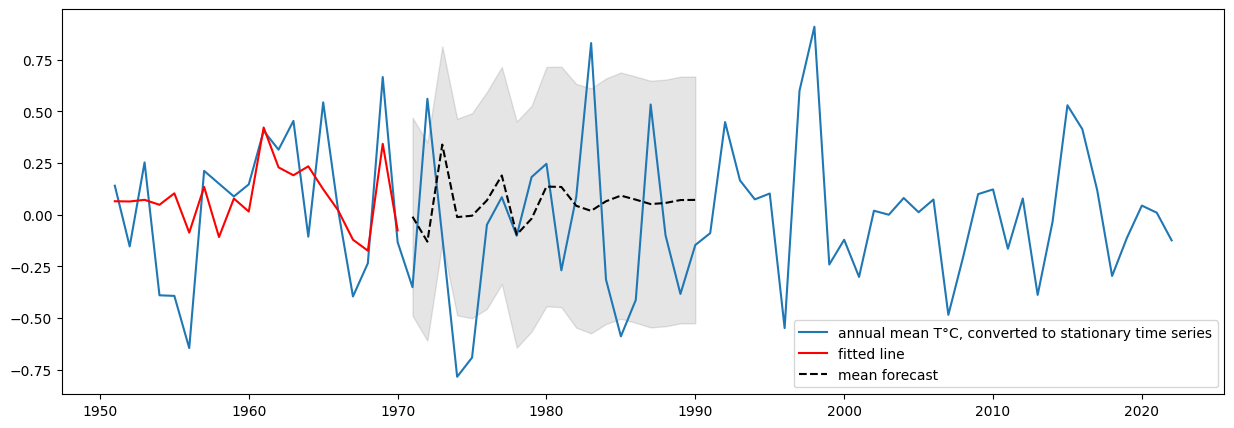

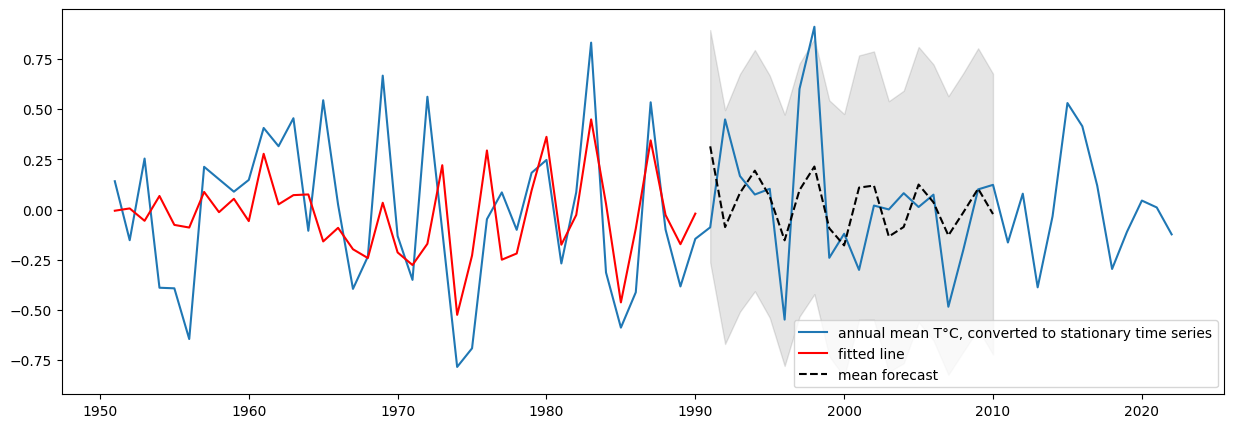

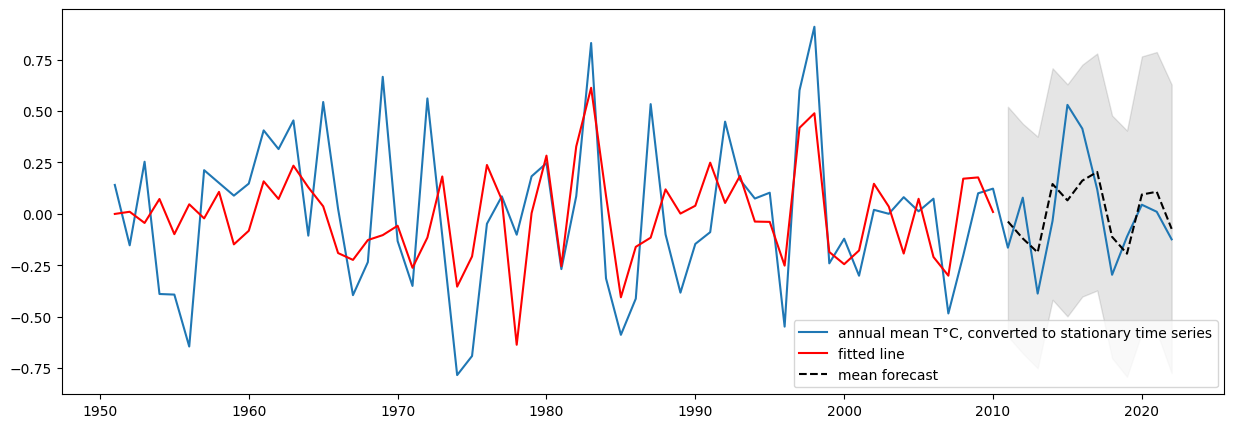

In [13]:
window_size = 20

for i in range(20,72,window_size):
    
    train_temp, test_temp = quadratic_residuals[:i], quadratic_residuals[i:i+window_size]
    train_date, test_date = X[:i], X[i:i+window_size]
    arma = ARIMA(train_temp, order=min_aic_index).fit()
    # print(arma.summary())
    fig, ax = plt.subplots(figsize=(15, 5))
    fcast = arma.get_forecast(len(test_temp)).summary_frame()

    arma_predictions = arma.predict()
    ax.plot(X, quadratic_residuals, label='annual mean T°C, converted to stationary time series')
    predicted_values = arma_predictions.reshape(-1,1)
    ax.plot(train_date, predicted_values, 'r', label='fitted line')
    forecast_means = fcast['mean'].values.reshape(-1,1)
    test_set_mse = np.mean((forecast_means.reshape(test_temp.shape) - test_temp)**2)
    ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
    ax.fill_between(test_date.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
    plt.legend();
    print("Test set mean squared error: ", test_set_mse)

In the first plot, we can see that only using 20 values for training, the forecast converge to the mean of the series. And, as we continue including data, the forcast improve.

Let's see if using an external variable (in this case the annual mean precipitation) improve our model.

c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameter

Test set mean squared error:  0.18613318748268368
Test set mean squared error:  0.11609711371821685


c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test set mean squared error:  0.07317563428347647


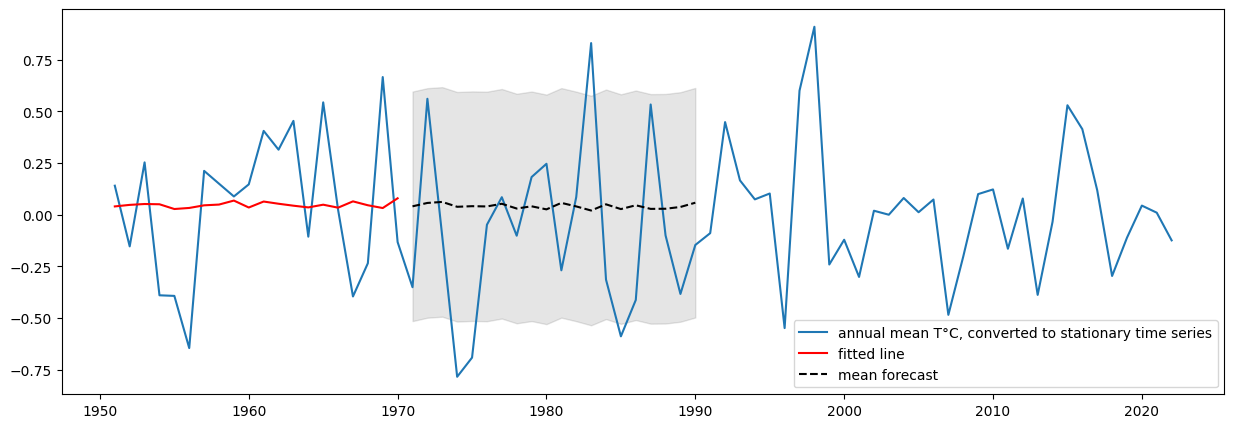

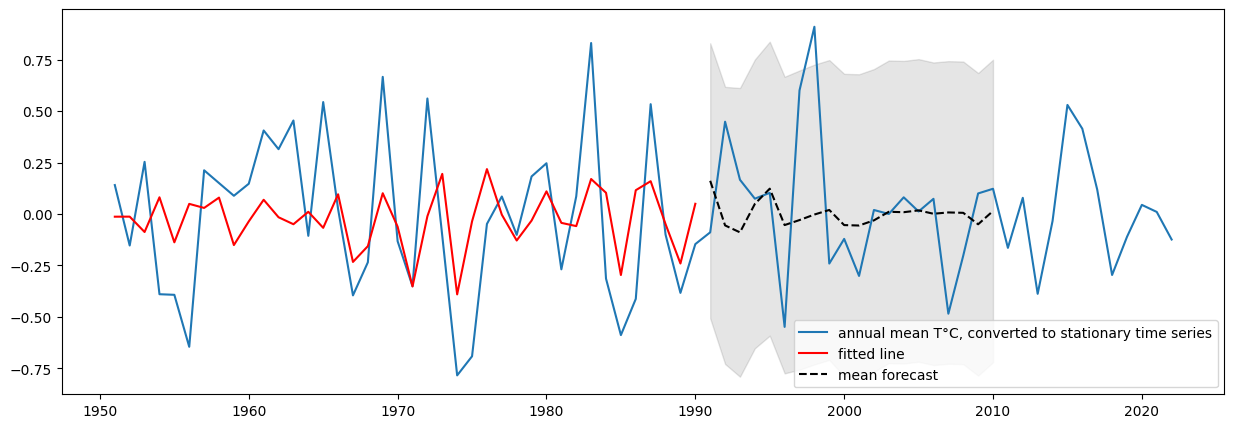

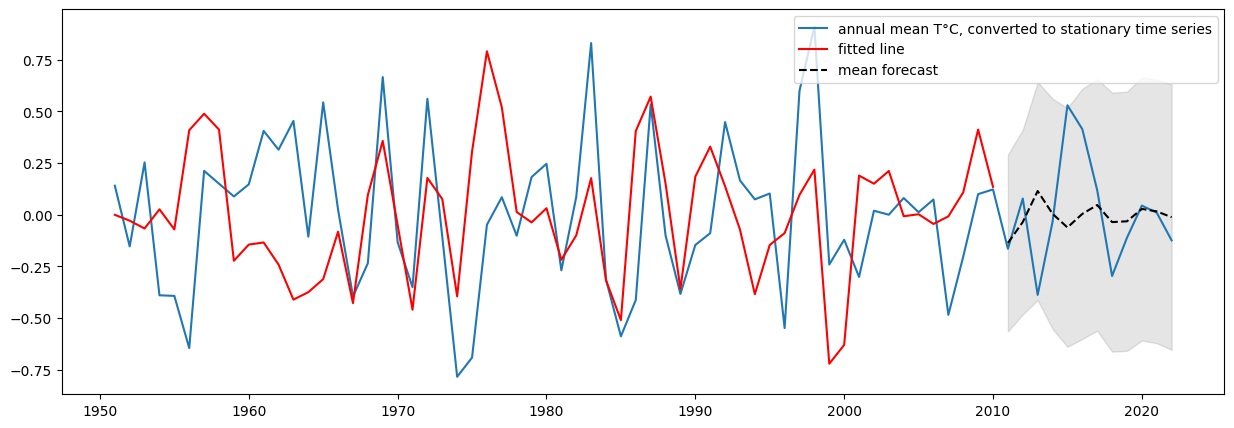

In [14]:
window_size = 20

for i in range(20,72,window_size):
    
    train_temp, test_temp = quadratic_residuals[:i], quadratic_residuals[i:i+window_size]
    train_date, test_date = X[:i], X[i:i+window_size]

    train_prec, test_prec = subset_df["Prec_annual_mean"].values.reshape(-1,1)[:i], subset_df["Prec_annual_mean"].values.reshape(-1,1)[i:i+window_size]


    arma = ARIMA(train_temp, order=min_aic_index, exog=train_prec).fit()
    # print(arma.summary())
    fig, ax = plt.subplots(figsize=(15, 5))
    fcast = arma.get_forecast(len(test_temp), exog=test_prec).summary_frame()

    arma_predictions = arma.predict()
    ax.plot(X, quadratic_residuals, label='annual mean T°C, converted to stationary time series')
    predicted_values = arma_predictions.reshape(-1,1)
    ax.plot(train_date, predicted_values, 'r', label='fitted line')
    forecast_means = fcast['mean'].values.reshape(-1,1)
    test_set_mse = np.mean((forecast_means.reshape(test_temp.shape) - test_temp)**2)
    ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
    ax.fill_between(test_date.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
    plt.legend();
    print("Test set mean squared error: ", test_set_mse)

We can see that including the precipitation doesn't improve the predictions of temperature on this ARMA(2,9) model. 
This analysis use the autoregressive models to get forecasts on time series data but, nowadays this methods can be extenden with deep learning models like recurrent neural networks or transformers to have better predictions. Also, is possible to make a temporal-spatial analysis using gaussian processes plus deep learning models.